# ECG Heartbeat Categorization

Tujuannya adalah untuk dapat mengklasifikasikan penyakit jantung dari sinyal detak jantung. Data yang digunakan berasal dari mit-bih database.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


#import os
#print(os.listdir("../content"))
# Any results you write to the current directory are saved as output.

from google.colab import drive
drive.mount('/content/drive')

data_training = pd.read_csv("../content/drive/My Drive/mitbih_train.csv", header=None)
data_testing  = pd.read_csv("../content/drive/My Drive/mitbih_test.csv", header=None)

print("MIT train dataset")
print(data_training.info())
print("MIT test dataset")
print(data_testing.info())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
MIT train dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None
MIT test dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
None


In [4]:
data_training[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

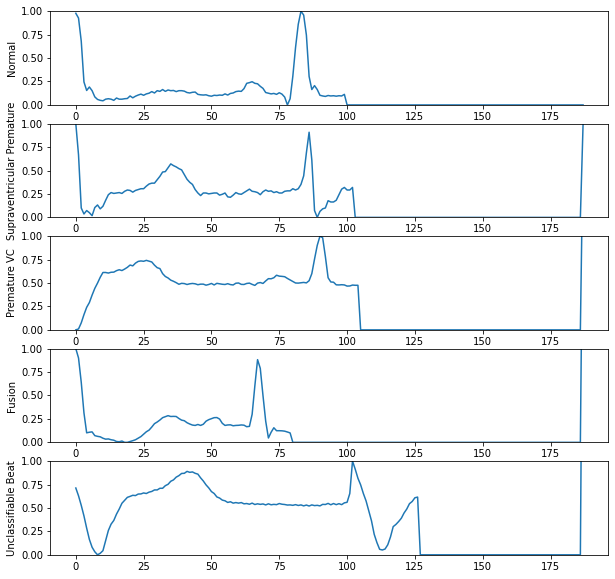

In [5]:
#gambaran signal data train masing-masing kategori
plt.figure(figsize=(10,10))

plt.subplot(5,1,1)
plt.ylabel("Normal")
plt.ylim(0,1)
plt.plot(data_training.loc[data_training[187] == 0.0].loc[0])

plt.subplot(5,1,2)
plt.ylabel("Supraventricular Premature")
plt.ylim(0,1)
plt.plot(data_training.loc[data_training[187] == 1.0].loc[72471])

plt.subplot(5,1,3)
plt.ylabel("Premature VC")
plt.ylim(0,1)
plt.plot(data_training.loc[data_training[187] == 2.0].loc[74694])

plt.subplot(5,1,4)
plt.ylabel("Fusion")
plt.ylim(0,1)
plt.plot(data_training.loc[data_training[187] == 3.0].loc[80482])

plt.subplot(5,1,5)
plt.ylabel("Unclassifiable Beat")
plt.ylim(0,1)
plt.plot(data_training.loc[data_training[187] == 4.0].loc[81123])

0: Normal beat

1: Supraventricular premature beat

2: Premature ventricular contraction

3: Fusion of ventricular and normal beat

4: Unclassifiable beat


In [6]:
data_training.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,0.198778,0.203550,0.208776,0.212885,0.218393,0.224966,0.231377,0.237123,0.242582,0.247923,0.253749,0.259748,0.266244,0.272734,0.279355,0.285588,0.291808,0.297672,0.303384,0.308795,0.313890,0.318454,0.322087,0.324891,0.326737,0.327817,0.327931,0.326746,0.324326,0.320537,...,0.030729,0.029582,0.028531,0.027573,0.026875,0.025771,0.024823,0.023932,0.023060,0.022458,0.021809,0.021245,0.020623,0.020026,0.019534,0.019053,0.018592,0.017664,0.016740,0.015722,0.014402,0.013024,0.011625,0.010262,0.008929,0.008056,0.007278,0.006531,0.005981,0.005479,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,0.171796,0.176496,0.180274,0.184101,0.186963,0.190002,0.193899,0.198465,0.202855,0.207166,0.211187,0.214821,0.218450,0.221486,0.224031,0.225848,0.227133,0.227830,0.228436,0.228871,0.228760,0.228393,0.227472,0.226180,0.224659,0.223110,0.221352,0.219258,0.216884,0.214168,...,0.116516,0.114463,0.112686,0.111103,0.110513,0.108566,0.106493,0.104591,0.102658,0.101395,0.100201,0.099386,0.098327,0.096635,0.095729,0.095368,0.095055,0.092902,0.091118,0.088574,0.084638,0.079949,0.075307,0.069892,0.063994,0.060074,0.056404,0.052840,0.050006,0.046693,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,0.070543,0.069182,0.068293,0.067744,0.070175,0.072993,0.074803,0.075972,0.076923,0.077872,0.079442,0.081911,0.085938,0.090032,0.094595,0.098901,0.103960,0.109348,0.114754,0.120730,0.127946,0.135962,0.144295,0.151852,0.157895,0.161035,0.161133,0.159383,0.157343,0.155388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [0]:
#data_training.iloc[19999].plot()

## Random sample

Sekarang kita akan melihat sampel acak dari dataset training.

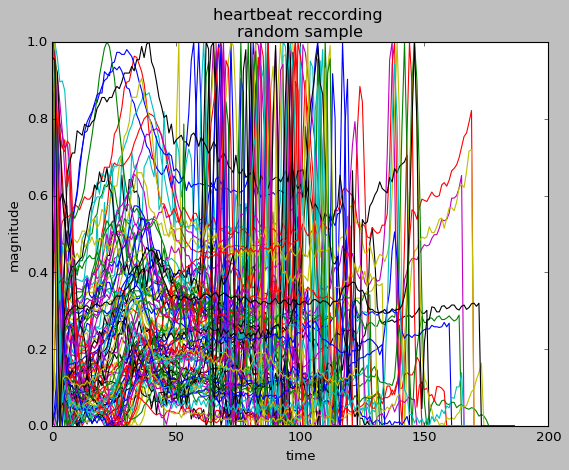

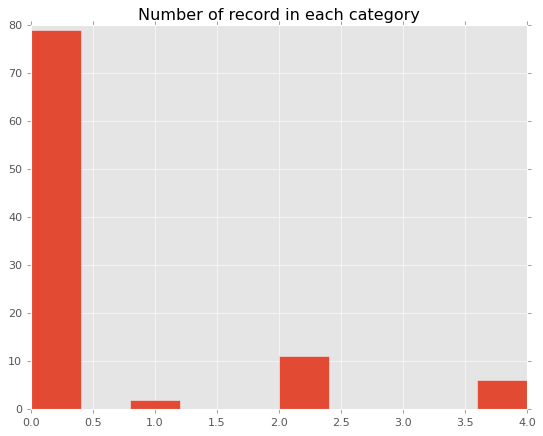

In [7]:
# take a random distribution
sample = data_testing.sample(98)

# remove the target column
sampleX = sample.iloc[:,sample.columns != 187]

import matplotlib.pyplot as plt

plt.style.use('classic')

# plt samples
for index, row in sampleX.iterrows():
    plt.plot(np.array(range(0, 187)) ,row)

plt.xlabel("time")
plt.ylabel("magnitude")
plt.title("heartbeat reccording \nrandom sample")

plt.show()

plt.style.use("ggplot")

plt.title("Number of record in each category")

plt.hist(sample.iloc[:,sample.columns == 187].transpose())
plt.show()

In [0]:
# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg' 

In [9]:
data_training.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
           dtype='int64', length=188)

In [0]:
columns = [0,1,2,3,4,5,6,187]

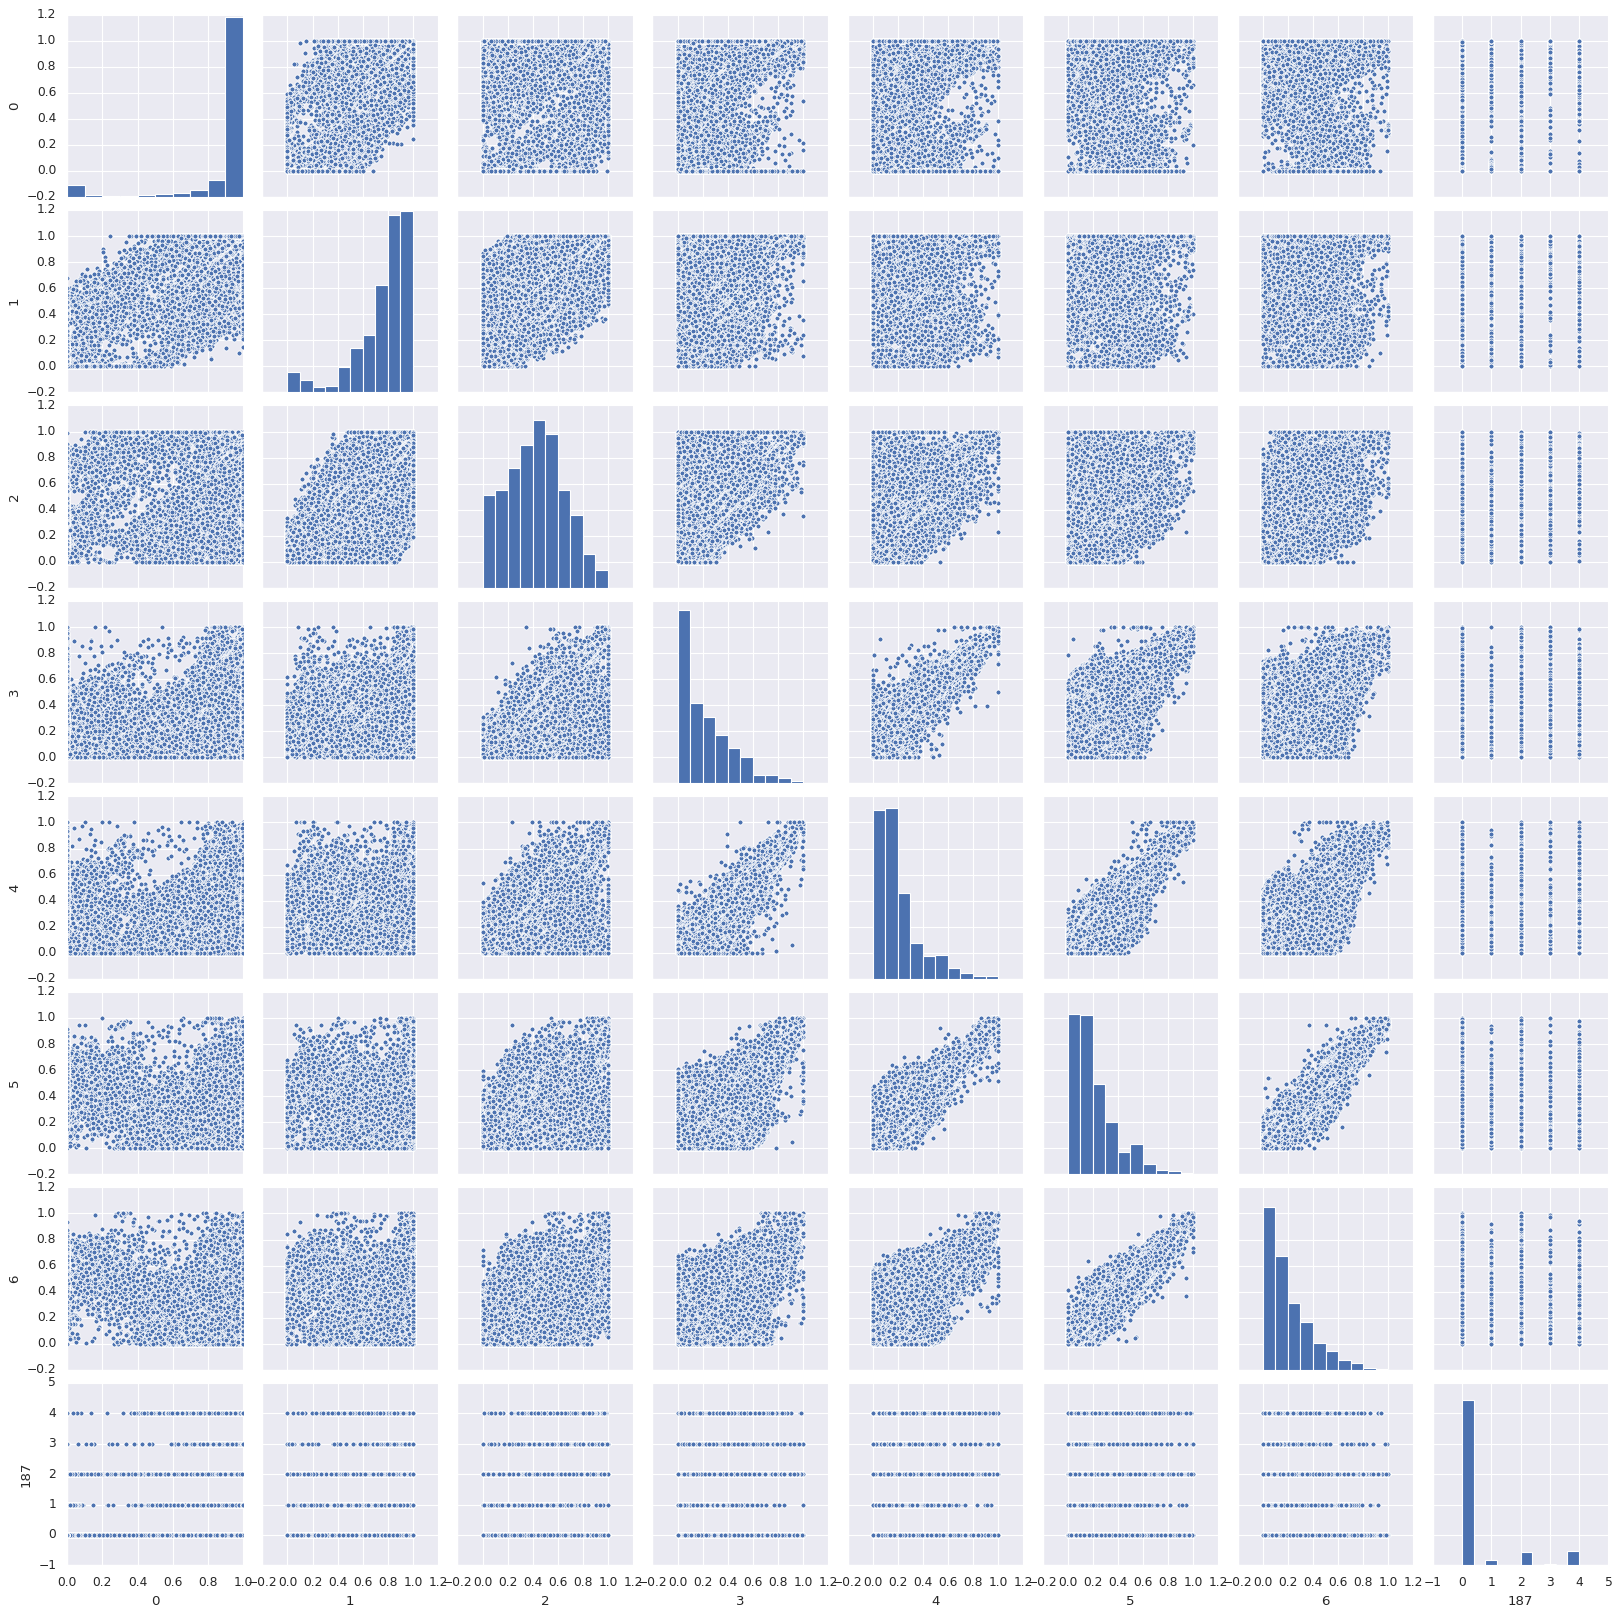

In [9]:
#`pairplot()` may become very slow with the SVG format
%config InlineBackend.figure_format = 'png'
sns.pairplot(data_training[columns]);

# How many data we have in each category?

In [11]:
print("Train data")
print("Type\tCount")
print((data_training[187]).value_counts())
print("-------------------------")
print("Test data")
print("Type\tCount")
print((data_testing[187]).value_counts())

Train data
Type	Count
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64
-------------------------
Test data
Type	Count
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


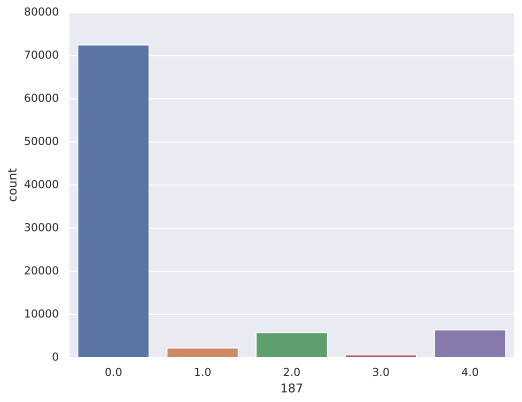

In [12]:
sns.countplot(x=187, data=data_training);

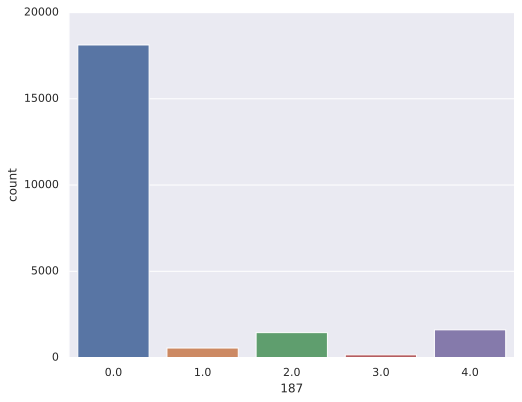

In [13]:
sns.countplot(x=187, data=data_testing);

# Separate features and targets

In [0]:
data_training = data_training.sample(frac=1)

In [15]:
from keras.utils import to_categorical

print("--- X ---")
X = data_training.loc[:, data_training.columns != 187]
print(X.head())
print(X.info())

print("--- Y ---")
y = data_training.loc[:, data_training.columns == 187]
y = to_categorical(y)

print("--- testX ---")
testX = data_testing.loc[:, data_testing.columns != 187]
print(testX.head())
print(testX.info())

print("--- testy ---")
testy = data_testing.loc[:, data_testing.columns == 187]
testy = to_categorical(testy)

--- X ---
            0         1         2         3    ...  183  184  185  186
37139  0.972881  0.518644  0.064407  0.128814  ...  0.0  0.0  0.0  0.0
53829  0.908676  0.792237  0.196347  0.000000  ...  0.0  0.0  0.0  0.0
59316  1.000000  0.782486  0.375706  0.000000  ...  0.0  0.0  0.0  0.0
84944  0.778675  0.672052  0.537964  0.379645  ...  0.0  0.0  0.0  0.0
87322  0.755700  0.511401  0.469055  0.459283  ...  0.0  0.0  0.0  0.0

[5 rows x 187 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87554 entries, 37139 to 54987
Columns: 187 entries, 0 to 186
dtypes: float64(187)
memory usage: 125.6 MB
None
--- Y ---
--- testX ---
        0         1         2         3         4    ...  182  183  184  185  186
0  1.000000  0.758264  0.111570  0.000000  0.080579  ...  0.0  0.0  0.0  0.0  0.0
1  0.908425  0.783883  0.531136  0.362637  0.366300  ...  0.0  0.0  0.0  0.0  0.0
2  0.730088  0.212389  0.000000  0.119469  0.101770  ...  0.0  0.0  0.0  0.0  0.0
3  1.000000  0.910417  0.681

# Keras model to make prediction

In [0]:
from keras import backend as K
    
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
 
    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Implementasi CNN


In [17]:
X.shape

(87554, 187)

In [18]:
y.shape

(87554, 5)

In [0]:
X = np.expand_dims(X,2)
testX = np.expand_dims(testX,2)

In [20]:
X.shape

(87554, 187, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Input, Flatten, SeparableConv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model

from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [0]:
n_obs, feature, depth = X.shape
batch_size = 512

In [0]:
def build_model():
    input_img = Input(shape=(feature, depth), name='ImageInput')
    x = Conv1D(32, 5, activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv1D(32, 5, activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling1D(2, name='pool1')(x)
    
    x = SeparableConv1D(64, 5, activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv1D(64, 5, activation='relu', padding='same', name='Conv2_2')(x)
    x = BatchNormalization(name='bn0')(x)
    x = MaxPooling1D(2, name='pool2')(x)
    
    x = SeparableConv1D(128, 5, activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling1D(2, name='pool3')(x)
    x = SeparableConv1D(128, 5, activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling1D(2, name='pool4')(x)
    
    x = SeparableConv1D(256, 5, activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling1D(2, name='pool5')(x)
    x = Dropout(0.5, name='dropout0')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [26]:
model =  build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 187, 1)            0         
_________________________________________________________________
Conv1_1 (Conv1D)             (None, 187, 32)           192       
_________________________________________________________________
Conv1_2 (Conv1D)             (None, 187, 32)           5152      
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 93, 32)            0         
_________________________________________________________________
Conv2_1 (SeparableConv1D)    (None, 93, 64)            2272      
_________________________________________________________________
Conv2_2 (SeparableConv1D)    (None, 93, 64)            4480      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 93, 64)            256 

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc',f1])

In [0]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/tmp/weights.hdf5", verbose=1, save_best_only=True)


In [29]:
history = model.fit(X, y, validation_split=0.2,epochs=100,batch_size=batch_size,shuffle=True,class_weight='auto',callbacks=[checkpointer])

Train on 70043 samples, validate on 17511 samples
Epoch 1/100
70043/70043 [==============================] - 83s 1ms/step - loss: 0.3894 - acc: 0.8935 - f1: 0.8725 - val_loss: 1.6031 - val_acc: 0.0684 - val_f1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.60311, saving model to /tmp/weights.hdf5
Epoch 2/100
70043/70043 [==============================] - 81s 1ms/step - loss: 0.1434 - acc: 0.9615 - f1: 0.9615 - val_loss: 1.6716 - val_acc: 0.0684 - val_f1: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.60311
Epoch 3/100
70043/70043 [==============================] - 84s 1ms/step - loss: 0.1076 - acc: 0.9717 - f1: 0.9716 - val_loss: 1.7677 - val_acc: 0.0684 - val_f1: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.60311
Epoch 4/100
70043/70043 [==============================] - 81s 1ms/step - loss: 0.0881 - acc: 0.9760 - f1: 0.9759 - val_loss: 2.1678 - val_acc: 0.1035 - val_f1: 0.0965

Epoch 00004: val_loss did not improve from 1.60311
Epoch 5/100
70043/70043

In [32]:
print("Evaluation: ")
mse, acc, F1 = model.evaluate(testX, testy)
print('mean_squared_error :', mse)
print('accuracy:', acc)
print('F1:', F1)

Evaluation: 
21892/21892 [==============================] - 9s 403us/step
mean_squared_error : 0.13071720256254543
accuracy: 0.9863877296447754
F1: 0.9863162040710449


In [0]:
model.save('cnn-0.986.h5')

In [0]:
y_pred = model.predict(testX, batch_size=256)

In [35]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

print(classification_report(testy.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.93      0.80      0.86       556
           2       0.97      0.95      0.96      1448
           3       0.86      0.74      0.79       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.90      0.92     21892
weighted avg       0.99      0.99      0.99     21892



Confusion matrix, without normalization


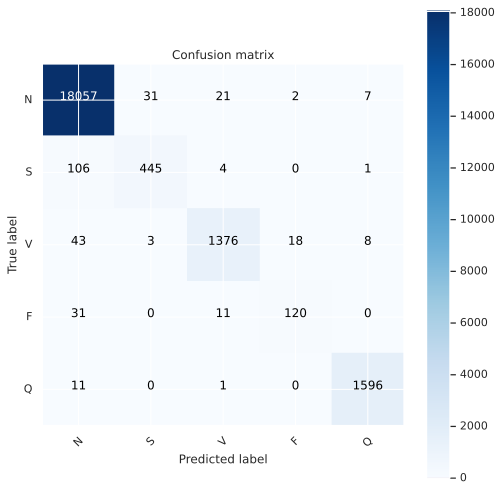

In [36]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(testy.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix')
plt.show()

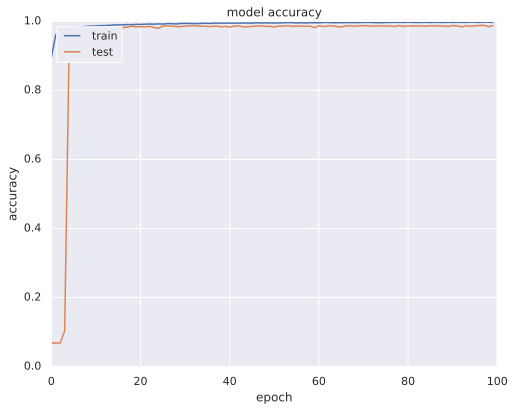

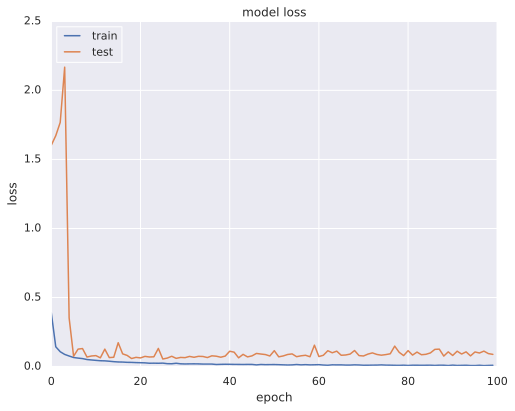

In [37]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Dengan Data Augmentation

In [0]:
#mit_train_data = mit_train_data.sample(frac=1)

In [39]:
from keras.utils import to_categorical

print("--- X ---")
X = data_training.loc[:, data_training.columns != 187]
print(X.head())
print(X.info())

print("--- Y ---")
y = data_training.loc[:, data_training.columns == 187]
#y = to_categorical(y)

print("--- testX ---")
testX = data_testing.loc[:, data_testing.columns != 187]
print(testX.head())
print(testX.info())

print("--- testy ---")
testy = data_testing.loc[:, data_testing.columns == 187]
testy = to_categorical(testy)

--- X ---
            0         1         2         3    ...  183  184  185  186
37139  0.972881  0.518644  0.064407  0.128814  ...  0.0  0.0  0.0  0.0
53829  0.908676  0.792237  0.196347  0.000000  ...  0.0  0.0  0.0  0.0
59316  1.000000  0.782486  0.375706  0.000000  ...  0.0  0.0  0.0  0.0
84944  0.778675  0.672052  0.537964  0.379645  ...  0.0  0.0  0.0  0.0
87322  0.755700  0.511401  0.469055  0.459283  ...  0.0  0.0  0.0  0.0

[5 rows x 187 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 87554 entries, 37139 to 54987
Columns: 187 entries, 0 to 186
dtypes: float64(187)
memory usage: 125.6 MB
None
--- Y ---
--- testX ---
        0         1         2         3         4    ...  182  183  184  185  186
0  1.000000  0.758264  0.111570  0.000000  0.080579  ...  0.0  0.0  0.0  0.0  0.0
1  0.908425  0.783883  0.531136  0.362637  0.366300  ...  0.0  0.0  0.0  0.0  0.0
2  0.730088  0.212389  0.000000  0.119469  0.101770  ...  0.0  0.0  0.0  0.0  0.0
3  1.000000  0.910417  0.681

In [40]:
X.shape,y.shape

((87554, 187), (87554, 1))

In [0]:
y = y.values.squeeze()

In [0]:
X = np.array(X)

In [0]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

In [44]:
print(C0.shape[0],C1.shape[0],C2.shape[0],C3.shape[0],C4.shape[0])

72471 2223 5788 641 6431


> Perbesar masing-masing C1 dan C3, C1 dan 4x, C3 dan 8x

In [0]:
import random
from scipy.signal import resample

def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (5, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

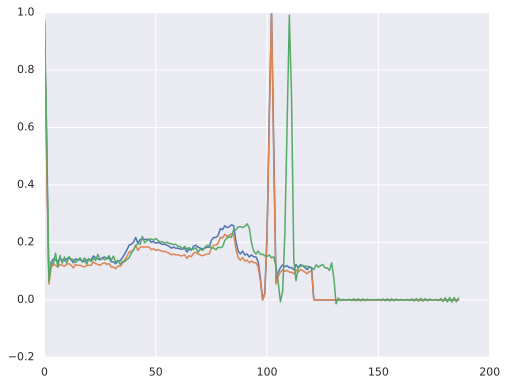

In [46]:
import matplotlib.pyplot as plt
import random
plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [0]:
result_C1 = np.apply_along_axis(augment, axis=1, arr=X[C1]).reshape(-1, 187)
class_C1 = np.ones(shape=(result_C1.shape[0],), dtype=int)*3

result_C3 = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
class_C3 = np.ones(shape=(result_C3.shape[0],), dtype=int)*3

# result_C32 = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
# class_C32 = np.ones(shape=(result_C32.shape[0],), dtype=int)*3

# X = np.vstack([X, result_C1, result_C3])
# y = np.hstack([y, class_C1, class_C3])

X = np.vstack([X,  result_C3])
y = np.hstack([y,  class_C3])

In [48]:
X.shape, y.shape

((90759, 187), (90759,))

In [0]:
y = to_categorical(y)

In [0]:
from sklearn.utils import shuffle
X, y = shuffle(X,y,random_state=0)

## Try a network by using augmented data

In [0]:
X = np.expand_dims(X,2)
testX = np.expand_dims(testX,2)

In [0]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Input, Flatten, SeparableConv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model

from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

n_obs, feature, depth = X.shape
batch_size = 1024

In [0]:
def build_model():
    input_img = Input(shape=(feature, depth), name='ImageInput')
    x = Conv1D(32, 5, activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv1D(32, 5, activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling1D(2, name='pool1')(x)
    
    x = SeparableConv1D(64, 5, activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv1D(64, 5, activation='relu', padding='same', name='Conv2_2')(x)
    x = BatchNormalization(name='bn0')(x)
    x = MaxPooling1D(2, name='pool2')(x)
    
    x = SeparableConv1D(128, 5, activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling1D(2, name='pool3')(x)
    x = SeparableConv1D(128, 5, activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling1D(2, name='pool4')(x)
    
    x = SeparableConv1D(256, 5, activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling1D(2, name='pool5')(x)
    x = Dropout(0.6, name='dropout0')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.6, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [53]:
model =  build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 187, 1)            0         
_________________________________________________________________
Conv1_1 (Conv1D)             (None, 187, 32)           192       
_________________________________________________________________
Conv1_2 (Conv1D)             (None, 187, 32)           5152      
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 93, 32)            0         
_________________________________________________________________
Conv2_1 (SeparableConv1D)    (None, 93, 64)            2272      
_________________________________________________________________
Conv2_2 (SeparableConv1D)    (None, 93, 64)            4480      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 93, 64)            256 

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc',f1])

In [0]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/tmp/weights-aug.hdf5", monitor='val_f1', mode='max', verbose=1, save_best_only=True)

In [56]:
history = model.fit(X, y, validation_split=0.2,epochs=100,batch_size=batch_size,class_weight='auto',callbacks=[checkpointer])

Train on 72607 samples, validate on 18152 samples
Epoch 1/100
72607/72607 [==============================] - 80s 1ms/step - loss: 0.6390 - acc: 0.8078 - f1: 0.7684 - val_loss: 1.5623 - val_acc: 0.0658 - val_f1: 0.0000e+00

Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to /tmp/weights-aug.hdf5
Epoch 2/100
72607/72607 [==============================] - 78s 1ms/step - loss: 0.2416 - acc: 0.9300 - f1: 0.9289 - val_loss: 1.7927 - val_acc: 0.0658 - val_f1: 0.0000e+00

Epoch 00002: val_f1 did not improve from 0.00000
Epoch 3/100
72607/72607 [==============================] - 77s 1ms/step - loss: 0.1569 - acc: 0.9589 - f1: 0.9588 - val_loss: 1.9266 - val_acc: 0.0658 - val_f1: 0.0000e+00

Epoch 00003: val_f1 did not improve from 0.00000
Epoch 4/100
72607/72607 [==============================] - 78s 1ms/step - loss: 0.1228 - acc: 0.9684 - f1: 0.9684 - val_loss: 2.0848 - val_acc: 0.0658 - val_f1: 0.0000e+00

Epoch 00004: val_f1 did not improve from 0.00000
Epoch 5/100
72607/7260

In [0]:
model.load_weights('/tmp/weights-aug.hdf5')

In [58]:
print("Evaluation: ")
mse, acc, F1 = model.evaluate(testX, testy)
print('mean_squared_error :', mse)
print('accuracy:', acc)
print('F1:', F1)

Evaluation: 
21892/21892 [==============================] - 8s 367us/step
mean_squared_error : 0.10358970223809705
accuracy: 0.9855654835700989
F1: 0.9855738878250122


In [59]:
K.set_value(model.optimizer.lr, 1e-4)
model.fit(X, y, validation_split=0.2,epochs=50,batch_size=batch_size,class_weight='auto',callbacks=[checkpointer])

Train on 72607 samples, validate on 18152 samples
Epoch 1/50
72607/72607 [==============================] - 75s 1ms/step - loss: 0.0054 - acc: 0.9983 - f1: 0.9983 - val_loss: 0.0592 - val_acc: 0.9899 - val_f1: 0.9899

Epoch 00001: val_f1 improved from 0.98866 to 0.98986, saving model to /tmp/weights-aug.hdf5
Epoch 2/50
72607/72607 [==============================] - 78s 1ms/step - loss: 0.0036 - acc: 0.9988 - f1: 0.9988 - val_loss: 0.0618 - val_acc: 0.9905 - val_f1: 0.9905

Epoch 00002: val_f1 improved from 0.98986 to 0.99047, saving model to /tmp/weights-aug.hdf5
Epoch 3/50
72607/72607 [==============================] - 75s 1ms/step - loss: 0.0037 - acc: 0.9987 - f1: 0.9987 - val_loss: 0.0674 - val_acc: 0.9902 - val_f1: 0.9902

Epoch 00003: val_f1 did not improve from 0.99047
Epoch 4/50
72607/72607 [==============================] - 74s 1ms/step - loss: 0.0029 - acc: 0.9991 - f1: 0.9991 - val_loss: 0.0702 - val_acc: 0.9902 - val_f1: 0.9903

Epoch 00004: val_f1 did not improve from 0.99

## The last Step: Using all the training data and fitting more epochs

In [60]:
#K.set_value(model.optimizer.lr, 1e-3)
history = model.fit(X, y, validation_data=(testX,testy),epochs=100,batch_size=batch_size*2,class_weight='auto',callbacks=[checkpointer])

Train on 90759 samples, validate on 21892 samples
Epoch 1/100
90759/90759 [==============================] - 98s 1ms/step - loss: 0.0221 - acc: 0.9971 - f1: 0.9971 - val_loss: 0.1284 - val_acc: 0.9858 - val_f1: 0.9858

Epoch 00001: val_f1 did not improve from 0.99087
Epoch 2/100
90759/90759 [==============================] - 97s 1ms/step - loss: 0.0127 - acc: 0.9974 - f1: 0.9973 - val_loss: 0.1161 - val_acc: 0.9860 - val_f1: 0.9861

Epoch 00002: val_f1 did not improve from 0.99087
Epoch 3/100
90759/90759 [==============================] - 98s 1ms/step - loss: 0.0111 - acc: 0.9975 - f1: 0.9975 - val_loss: 0.1050 - val_acc: 0.9867 - val_f1: 0.9868

Epoch 00003: val_f1 did not improve from 0.99087
Epoch 4/100
90759/90759 [==============================] - 98s 1ms/step - loss: 0.0101 - acc: 0.9980 - f1: 0.9980 - val_loss: 0.1033 - val_acc: 0.9862 - val_f1: 0.9864

Epoch 00004: val_f1 did not improve from 0.99087
Epoch 5/100
90759/90759 [==============================] - 98s 1ms/step - loss

In [0]:
model.load_weights('/tmp/weights-aug.hdf5')

In [63]:
K.set_value(model.optimizer.lr, 1e-5)
history = model.fit(X, y, validation_data=(testX,testy),epochs=50,batch_size=batch_size*2,class_weight='auto',callbacks=[checkpointer])

Train on 90759 samples, validate on 21892 samples
Epoch 1/50
90759/90759 [==============================] - 98s 1ms/step - loss: 0.0238 - acc: 0.9976 - f1: 0.9976 - val_loss: 0.1575 - val_acc: 0.9870 - val_f1: 0.9872

Epoch 00001: val_f1 did not improve from 0.99087
Epoch 2/50
90759/90759 [==============================] - 97s 1ms/step - loss: 0.0199 - acc: 0.9975 - f1: 0.9975 - val_loss: 0.1487 - val_acc: 0.9869 - val_f1: 0.9870

Epoch 00002: val_f1 did not improve from 0.99087
Epoch 3/50
90759/90759 [==============================] - 97s 1ms/step - loss: 0.0191 - acc: 0.9975 - f1: 0.9975 - val_loss: 0.1447 - val_acc: 0.9866 - val_f1: 0.9867

Epoch 00003: val_f1 did not improve from 0.99087
Epoch 4/50
90759/90759 [==============================] - 96s 1ms/step - loss: 0.0195 - acc: 0.9974 - f1: 0.9975 - val_loss: 0.1395 - val_acc: 0.9865 - val_f1: 0.9866

Epoch 00004: val_f1 did not improve from 0.99087
Epoch 5/50
90759/90759 [==============================] - 96s 1ms/step - loss: 0.0

In [64]:
model.load_weights('/tmp/weights-aug.hdf5')
print("Evaluation: ")
mse, acc, F1 = model.evaluate(testX, testy)
print('mean_squared_error :', mse)
print('accuracy:', acc)
print('F1:', F1)

Evaluation: 
21892/21892 [==============================] - 10s 437us/step
mean_squared_error : 0.17443062552029315
accuracy: 0.9872099161148071
F1: 0.9872472882270813


In [0]:
model.save("0.9872.hdf5")

Confusion matrix, without normalization


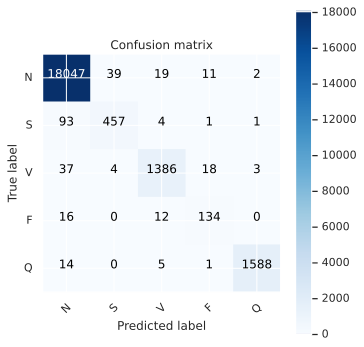

In [66]:
y_pred = model.predict(testX, batch_size=256)
# Compute confusion matrix
cnf_matrix = confusion_matrix(testy.argmax(axis=1), y_pred.argmax(axis=1))
#np.set_printoptions(precision=0)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix')
plt.show()